## Project **Rules**

##Rules for the project evaluation:
- The project is personal
- You must write a short report in PDF format. You must send the Python code (eg Jupyter notebook) separately and put everything in a zip archive for uploading. 
- The report must as often as possible link the obtained results with the theory of the course.
- **The report must comment on the results and compare different methods whenever possible** (in terms of speed of convergence and performance on train and test sets).
- You should include relevant illustrating piece code in their report, but only if it is relevant to explain a method (no need to copy/paste the code given to them).
- You must use as much as possible the code given to you during the course, **you should not rely on external library like sklearn** (you can use them only to check you get the same results)
- We impose a list of things to do linked to the first 8 courses, and propose some optional things (see below).

##Optional things (examples): 
- test of more complicated models (multi-layer perceptron, impact of #layers on train/test errors)
- test of alternate ML methods (svm, group lasso, etc)
- test of stochastic gradient with momentum
- test of variance reduction techniques
- test of higher order optimization method (BFGS / Newton)
- use of automatic differentiation
- test of online learning
- Use of early stopping and its impact on test error
- compare different algorithms on non-convex problems in terms of speed but also performances.


##Mandatory things to put in the report:

- Presentation of the dataset. It should be medium scale (~10K points/features), and as original as possible. This part can include some useful visualization (1D display of features, histogramming, pca, t-sne, etc).
- Presentation of the problem. It can be either classification (2 or more classes) or regression.
- **Test of batch gradient descent, with exploration of at least the descent step size and link with the course.**
- **Test of accelerated gradient descent (Nesterov),**
- **Test of stochastic gradient descent (impact of hyperparameters such as learning rate, (mini)-batch size, diagonal scaling, etc)**
- **Test of regularization (ridge/lasso using iterative soft thresholding)**





## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Optimisation/Projet Optim')

In [ ]:
import numpy as np
import time
from scipy import stats
from sklearn import preprocessing


import matplotlib.pyplot as plt
from numpy.linalg import inv, norm
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
from IPython.display import Image
sns.set(rc={'figure.figsize':(12,6)})

from random import shuffle

# Decribe dataset and Pre processing

DATASET FROM http://archive.ics.uci.edu/ml/datasets/Superconductivty+Data

In this notebook, we aim to predict the critical temperature of some superconductors from 81 features extracted from 21263 measure points. The original data is public.

To do so, we want to model the critical temperature using a polynomial regression of degree 3. 

In dimension 2, this means that our target label can be expressed as a combination of features and product of features such as:
$$ \hat{y} = w_0 + w_1 x_1 + w_2 x_2 +w_3 x_1x_2 + w_4 x_1^2 + w_5 x_2^2$$

where the $w_i$ are the coefficient of our model, and $x_i$ the different features of our dataset. 

A polynomial regression can be viewed as a special case of Linear transformation where the vectors of feature containig the $x_i$ are transformed like so:

$$\hat{y} = [x_1, x_2, x_1x_2, x_1^2, x_2^2]w$$

or in matrix notation $$\hat{Y}=Xw$$



Since we are doing regression we choose to optimize via the use of the half of **Mean Squared Error (MSE loss)** in the objective function. We also add an $l_2$ regularization associated with a parameter $\lambda$ to restrained the solutions to a ball. The problem can be written as per the following expression:

$$
\min L(w) = \frac{1}{2n} \sum_{i=1}^{n}\left(\hat{y}_{i}-y_{i}\right)^{2} + \frac{\lambda}{2} ||w||^2 = \frac{1}{2n}  \|X w-Y \|^{2}_{2} + \frac{\lambda}{2} ||w||^2 = \frac{1}{n} \left(\frac{1}{2}\sum_{i=1}^n (\mathbf{x}_i^T \mathbf{w} - y_i)^2 + \frac{\lambda}{2}\|\mathbf{w}\|^2 \right)
$$

$ \underline{where:} $

- **n** the number of samples in the dataset.

- **d** the number of independant features in the dataset.

- **k** the number of selected features combined with the total number of interactions features (binomial coefficient for polynomial regression)


- $ w=\left[w_{0}, \ldots, w_{k}\right]^{T} $ the weight vector of size $ \mathbb{R}^{k+1} $, where $w_0$ is the bias and $ w_{1}, \ldots, w_{k} $ are the weights.


- $ Y = \left[y_{1}, y_{2}, \ldots, y_{n}\right]^{T} $ the label vector of size $ \mathbb{R}^{n} $, where every $ y_{i} $ is the critical temperature of sample i.


- $ X $ of size $ \mathbb{R}^{k+1} $The transformed feature matrix with all polynomial coefficients

- $ \hat{Y}=X w=\left[\hat{y}_{1}, \hat{y}_{2}, \ldots, \hat{y}_{n}\right]^{\top} $ the vector of predictions of size $ \mathbb{R}^{n} $

This problem has the form of a finite sum $f(\mathbf{w})=\tfrac{1}{n}\sum_{i=1}^n f_i(\mathbf{w})$, where 
$$
    f_i(\mathbf{w}) = \frac{1}{2} (\mathbf{x}_i^T \mathbf{w} - y_i)^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2.
$$

In addition

- ***$\nabla f_i(\mathbf{w}) = (\mathbf{x}_i^T \mathbf{w} - y_i)\mathbf{x}_i + \lambda \mathbf{w}$ for every $i$;***
- ***$\nabla f(\mathbf{w}) =\frac{1}{n}\mathbf{X}^T (\mathbf{X} \mathbf{w} - \mathbf{y}) + \lambda\mathbf{w}$;***
- ***$\nabla f$ is $L=\frac{\|\mathbf{X}^T \mathbf{X}\|}{n}+\lambda$ Lipschitz continuous.***


## 1) Data pre-processing

In [ ]:
DF = pd.read_csv('superconductive_data.csv', sep=',')

DF.head(2)

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,...,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,53.622535,775.425,1010.268571,718.152900,938.016780,1.305967,0.791488,810.6,735.985714,323.811808,355.562967,160.25,105.514286,136.126003,84.528423,1.259244,1.207040,205,42.914286,75.237540,69.235569,4654.35725,2961.502286,724.953211,53.543811,1.033129,0.814598,8958.571,1579.583429,3306.162897,...,111.727143,60.123179,99.414682,1.159687,0.787382,127.05,80.987143,51.433712,42.558396,6.9055,3.846857,3.479475,1.040986,1.088575,0.994998,12.878,1.744571,4.599064,4.66692,107.756645,61.015189,7.062488,0.621979,0.308148,0.262848,399.97342,57.127669,168.854244,138.517163,2.25,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,53.979870,766.440,1010.612857,720.605511,938.745413,1.544145,0.807078,810.6,743.164286,290.183029,354.963511,161.20,104.971429,141.465215,84.370167,1.508328,1.204115,205,50.571429,67.321319,68.008817,5821.48580,3021.016571,1237.095080,54.095718,1.314442,0.914802,10488.571,1667.383429,3767.403176,...,112.316429,69.833315,101.166398,1.427997,0.838666,127.05,81.207857,49.438167,41.667621,7.7844,3.796857,4.403790,1.035251,1.374977,1.073094,12.878,1.595714,4.473363,4.60300,172.205316,61.372331,16.064228,0.619735,0.847404,0.567706,429.97342,51.413383,198.554600,139.630922,2.00,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0


In [ ]:
#define target feature
target='critical_temp'
DF.shape

(21263, 82)

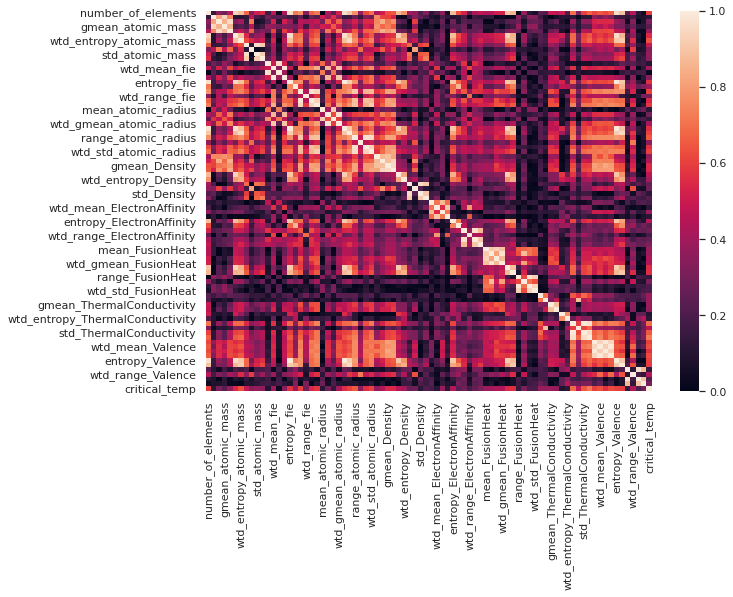

In [ ]:
# Plot the correlation matrix between features
correlation_matrix = DF.corr().round(2).abs()

plt.figure(figsize=(10,7))
sns.heatmap(data=correlation_matrix, annot=False)
plt.show()

In [ ]:
#remove outliers

DF=DF[(np.abs(stats.zscore(DF)) < 6).all(axis=1)]
print("After removing outliers (> 6 STD), size of data is:",DF.shape)


# Performs a PCA

labels, features = DF[[target]], DF.drop(target,1)

from sklearn.decomposition import PCA
pca = PCA(n_components=25)
pca.fit(features)
features=pca.transform(features)
features=pd.DataFrame(features)
print('PCA: variance explained ',pca.explained_variance_ratio_.sum(),' new number of pca features: ',len(pca.singular_values_))


#normalization

scaler = preprocessing.MinMaxScaler()
names = features.columns
d = scaler.fit_transform(features)
features = pd.DataFrame(d, columns=names)

scaler = preprocessing.MinMaxScaler()
names = labels.columns
d = scaler.fit_transform(labels)
labels = pd.DataFrame(d, columns=names)

print("Data rescaled.")

features.head(2)

After removing outliers (> 6 STD), size of data is: (20898, 82)
PCA: variance explained  0.9999870812578466  new number of pca features:  25
Data rescaled.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,0.047073,0.375594,0.374829,0.440567,0.449115,0.298498,0.375365,0.335156,0.505628,0.312294,0.268982,0.378096,0.532991,0.424552,0.421488,0.549304,0.412246,0.393956,0.377820,0.537226,0.526560,0.441823,0.512612,0.392078,0.523227
1,0.059359,0.433467,0.347680,0.487163,0.466909,0.368904,0.375503,0.335002,0.461624,0.333011,0.234633,0.428113,0.527662,0.421656,0.452566,0.532102,0.456343,0.273688,0.390068,0.489906,0.620274,0.497575,0.454018,0.350948,0.436247


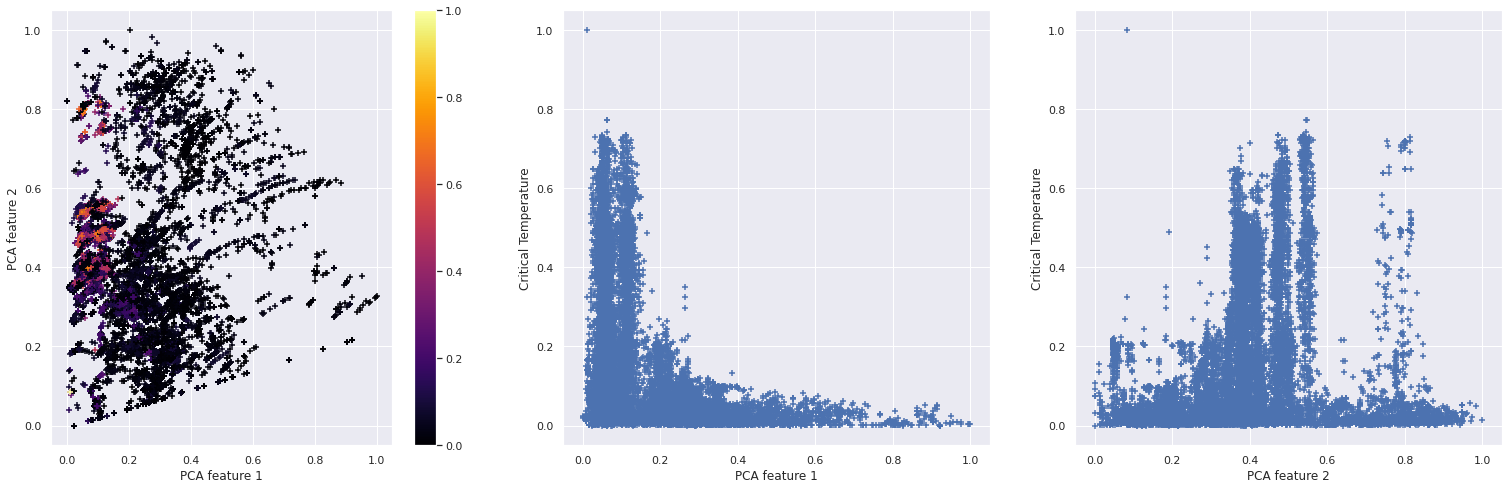

In [ ]:
#Visualisation Plots of another PCA with only 2 features

plt.figure(figsize=(26,8))

plt.subplot(131)
plt.scatter(features.values[:,0],features.values[:,1], c=labels.values, cmap='inferno', marker='+')
plt.colorbar()
plt.xlabel("PCA feature 1")
plt.ylabel("PCA feature 2")

plt.subplot(132)
plt.scatter(features.values[:,0],labels.values, marker='+')
plt.xlabel("PCA feature 1")
plt.ylabel("Critical Temperature")

plt.subplot(133)
plt.scatter(features.values[:,1],labels.values,marker='+')
plt.xlabel("PCA feature 2")
plt.ylabel("Critical Temperature")

plt.show()

In [ ]:
# Train/Test Split

XX, X_test, YY, y_test = train_test_split(features, labels, test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(XX, YY, test_size=0.25, random_state=1)
X_train.shape

(12538, 25)

In [ ]:
#changing our samples data matrix into ones to perform polynomial regression

from sklearn.preprocessing import PolynomialFeatures

pol_degree=3

poly = PolynomialFeatures(degree=pol_degree)
X_train = poly.fit_transform(X_train)
X_train = pd.DataFrame(X_train)

poly = PolynomialFeatures(degree=pol_degree)
X_test = poly.fit_transform(X_test)
X_test = pd.DataFrame(X_test)

poly = PolynomialFeatures(degree=pol_degree)
X_val = poly.fit_transform(X_val)
X_val = pd.DataFrame(X_val)

X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3236,3237,3238,3239,3240,3241,3242,3243,3244,3245,3246,3247,3248,3249,3250,3251,3252,3253,3254,3255,3256,3257,3258,3259,3260,3261,3262,3263,3264,3265,3266,3267,3268,3269,3270,3271,3272,3273,3274,3275
0,1.0,0.093596,0.479078,0.399032,0.361378,0.462743,0.355302,0.396071,0.479293,0.389413,0.251431,0.218129,0.444698,0.462512,0.314066,0.406583,0.395731,0.405527,0.486114,0.444810,0.471058,0.455881,0.444270,0.382643,0.492340,0.355284,0.008760,0.044840,0.037348,0.033824,0.043311,0.033255,0.037071,0.044860,0.036448,0.023533,0.020416,0.041622,0.043289,0.029395,...,0.088743,0.064039,0.114184,0.082398,0.059460,0.094745,0.092331,0.079524,0.102322,0.073838,0.089980,0.077498,0.099716,0.071957,0.066748,0.085884,0.061976,0.110505,0.079743,0.057544,0.087688,0.075525,0.097176,0.070125,0.065048,0.083696,0.060397,0.107691,0.077712,0.056079,0.056025,0.072086,0.052019,0.092752,0.066932,0.048300,0.119343,0.086121,0.062147,0.044847
1,1.0,0.062758,0.538379,0.306685,0.471489,0.426756,0.411920,0.270544,0.344776,0.418733,0.501827,0.202454,0.516327,0.487995,0.543633,0.248303,0.469713,0.405767,0.444005,0.457226,0.584171,0.423826,0.551254,0.281814,0.500753,0.393828,0.003939,0.033787,0.019247,0.029590,0.026782,0.025851,0.016979,0.021637,0.026279,0.031494,0.012706,0.032404,0.030625,0.034117,...,0.082438,0.064835,0.146483,0.115205,0.090605,0.076131,0.099021,0.050622,0.089949,0.070743,0.128793,0.065842,0.116994,0.092012,0.033660,0.059810,0.047039,0.106276,0.083583,0.065736,0.167516,0.085638,0.152169,0.119677,0.043780,0.077792,0.061182,0.138229,0.108713,0.085500,0.022381,0.039769,0.031277,0.070666,0.055577,0.043709,0.125566,0.098754,0.077667,0.061083


### Global function definition

In [ ]:
#Linear model

def linear_prediction(X,W):
  return np.dot(X,W)

def linear_gradient(X,W,Y,lamda):
  n=X.shape[0]
  return 1/n * np.dot((np.dot(X, W) - Y).T, X) + lamda*W.T

def lipschitz_constant(X):
  n=X.shape[0]
  return 1/n * norm(np.dot(X.T,X))


#batch sampling fct

def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# Metrics

def R2_score(Y_pred,Y):
    u,v=((Y - Y_pred)** 2).sum(),((Y - Y.mean()) ** 2).sum()
    R2score = 1-(u/v)
    return R2score

def MSE_loss(Y_pred,Y):
  n=Y.shape[0]
  return 1/n * norm(Y_pred - Y)**2

useful fcts

In [ ]:
#RUN
def RUN_and_EVAL(f,X_train,Y_train,tau,n_epochs,batch_size,beta,test_val_data):
  t1 = time.time()
  W, train_loss, test_loss = f(X_train, Y_train, tau, n_epochs,batch_size,beta,test_val_data)
  t2 = time.time() - t1
  print("The training is over in {}s".format(round(t2, 2)))

  return W, train_loss, test_loss

def PLOT_history(train_loss,test_loss,title):
  
  plt.figure(figsize=(15,4),dpi=80)
  plt.suptitle('Loss and Predictions plot')

  plt.subplot(121,title=title)
  plt.plot(train_loss,label='train loss')
  plt.plot(test_loss,label='test loss')
  plt.xlabel("Number of epochs")
  plt.ylabel("MSE Loss")
  plt.legend()

  plt.show()

### Hyper Parameters

In [ ]:
#Hyper Params

n_epochs = 100

lamda=0 #regularization parameter

In [ ]:
L=lipschitz_constant(X_train) #lipschitz_constant parameter for learning rate benchmark
L

31.01726109244756

## 2 - Vanilla gradient descent

**Gradient Descent** is a famous algorithm we use to solve optimization problems especially for minimizing our loss function $ L(w) $. The algorithm starts by intializing random weights to the vector $ w $, and updates it in the opposite direction of the gradient $ \nabla_{w} L $, with a quantity called **the learning rate** $ \tau $. 

$ \tau $ mainly controls the speed of convergence and the final accuracy of the solution. With k the number of current iteration, the algo can be summarized by:

$$
\boxed{w^{(k+1)} = w^{(k)}-\tau \nabla_w L\left(w^{(k)}\right)}
$$



In [ ]:
#VGD
def vanilla_gradient_descent(X, Y, tau, n_epochs,batch_size,beta,test_val_data):
    W = np.zeros((X.shape[1], 1))
    n_samples = X.shape[0]
    X=X.values
    Y=Y.values

    if test_val_data=='test':
      XX=X_test
      YY=y_test
    if test_val_data=='val':
      XX=X_val
      YY=y_val

    train_loss = []
    test_loss = []

    for epoch in range(1, n_epochs+1):

      train_loss.append(MSE_loss(linear_prediction(X, W),Y))
      test_loss.append(MSE_loss(linear_prediction(XX, W),YY))

      grad = linear_gradient(X,W,Y,lamda)
      W = W - tau*grad.T


      if epoch%5==0:
        #print("Epoch: {}/{} | Train Loss: {}".format(epoch, n_epochs, train_loss[-1]))
        print("Epoch: {}/{} | Test Loss: {}".format(epoch, n_epochs, test_loss[-1]))

    return W, train_loss, test_loss

Epoch: 5/100 | Test Loss: 0.03408914012355545
Epoch: 10/100 | Test Loss: 0.032658745300173396
Epoch: 15/100 | Test Loss: 0.03135063820883058
Epoch: 20/100 | Test Loss: 0.030152818545330678
Epoch: 25/100 | Test Loss: 0.029054546417099134
Epoch: 30/100 | Test Loss: 0.028046205491904102
Epoch: 35/100 | Test Loss: 0.027119181263377288
Epoch: 40/100 | Test Loss: 0.026265752746596885
Epoch: 45/100 | Test Loss: 0.025478996106512494
Epoch: 50/100 | Test Loss: 0.024752698890096497
Epoch: 55/100 | Test Loss: 0.02408128368222628
Epoch: 60/100 | Test Loss: 0.023459740137596257
Epoch: 65/100 | Test Loss: 0.022883564458333557
Epoch: 70/100 | Test Loss: 0.022348705491139594
Epoch: 75/100 | Test Loss: 0.021851516710198565
Epoch: 80/100 | Test Loss: 0.021388713434112864
Epoch: 85/100 | Test Loss: 0.02095733469791892
Epoch: 90/100 | Test Loss: 0.020554709265850152
Epoch: 95/100 | Test Loss: 0.02017842532786898
Epoch: 100/100 | Test Loss: 0.01982630347390831
The training is over in 5.09s


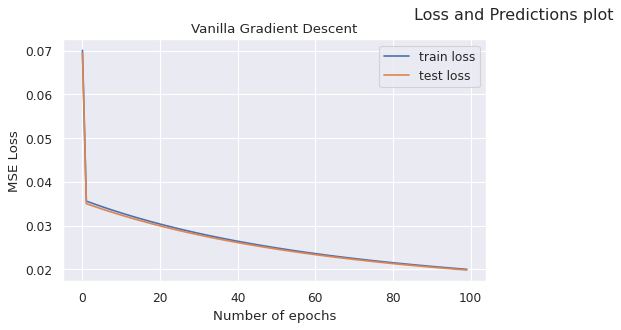

In [ ]:
tau = 1/L
beta=0 #not applicable here
batch_size=0 #not applicable here


#RUN
W_vgd, train_loss_vgd, test_loss_vgd = RUN_and_EVAL(vanilla_gradient_descent,X_train, y_train, tau, n_epochs, batch_size,beta,'test')
#PlOT
PLOT_history(train_loss_vgd,test_loss_vgd,'Vanilla Gradient Descent')

###Hyper Params search

Epoch: 5/100 | Test Loss: 0.06748806560217699
Epoch: 10/100 | Test Loss: 0.0627130035332382
Epoch: 15/100 | Test Loss: 0.06192812280151279
Epoch: 20/100 | Test Loss: 0.058195503068792655
Epoch: 25/100 | Test Loss: 0.05780627321115754
Epoch: 30/100 | Test Loss: 0.05481132695813096
Epoch: 35/100 | Test Loss: 0.054651721084255284
Epoch: 40/100 | Test Loss: 0.05219070580427053
Epoch: 45/100 | Test Loss: 0.05216019949670829
Epoch: 50/100 | Test Loss: 0.05009464539658906
Epoch: 55/100 | Test Loss: 0.050132871282911655
Epoch: 60/100 | Test Loss: 0.048366929822495616
Epoch: 65/100 | Test Loss: 0.04843807009936859
Epoch: 70/100 | Test Loss: 0.04690407116152664
Epoch: 75/100 | Test Loss: 0.046987257184006405
Epoch: 80/100 | Test Loss: 0.04563642898049996
Epoch: 85/100 | Test Loss: 0.04571984515016489
Epoch: 90/100 | Test Loss: 0.044516296340982885
Epoch: 95/100 | Test Loss: 0.04459356688673492
Epoch: 100/100 | Test Loss: 0.043510341626367535
The training is over in 5.1s
Epoch: 5/100 | Test Loss:

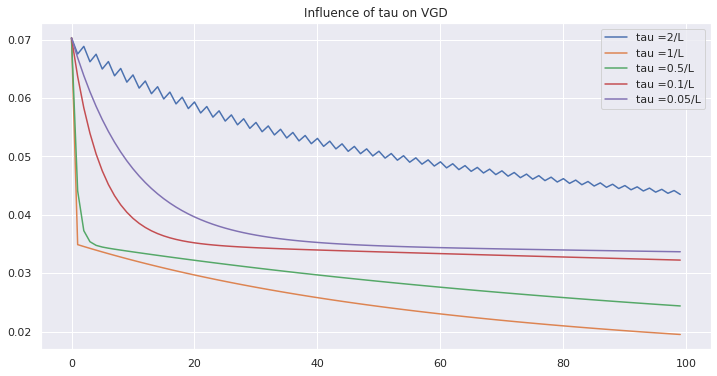

In [ ]:
taus=[2,1,0.5,0.1,0.05] #divided by L in RUN_and_EVAL function call

for tauu in taus:
  a, b, c  = RUN_and_EVAL(vanilla_gradient_descent,X_train, y_train, tauu/L, n_epochs,batch_size,beta,'val')
  plt.plot(c,label='tau ='+str(tauu)+'/L')
plt.title('Influence of tau on VGD')
plt.legend()
plt.show()

## 3 - Stochastic Gradient Descent (SGD)

**Stochastic Gradient Descent (SGD)** will perform the gradient computing for every sample in the dataset. Therefore, one update of the weights is performed for every training sample, which makes it more efficient than VGD when having huge datasets. The $i_k$ are drawn at random uniformely in $\{1,\dots,n\}$.

$$
\boxed{\forall ik \in\{1, \ldots, n\}:  w^{(k+1)} = w^{(k)}-\tau \nabla L_{w}\left(w^{(k)}, X^{(ik)}, Y^{(ik)}\right)}
$$

In [ ]:
#SGD
def stochastic_gradient_descent(X, Y, tau, n_epochs,batch_size,beta,test_val_data):
    W = np.zeros((X.shape[1],1))
    n_samples = X.shape[0]
    train_loss = []     
    test_loss = []
    X=X.values
    Y=Y.values

    if test_val_data=='test':
      XX=X_test
      YY=y_test
    if test_val_data=='val':
      XX=X_val
      YY=y_val

    for epoch in range(1, n_epochs+1):
        shuffle_index=[j for j in range(n_samples)]
        shuffle(shuffle_index)

        train_loss.append(MSE_loss(linear_prediction(X, W),Y))
        test_loss.append(MSE_loss(linear_prediction(XX, W),YY))

        for batch_list in batch(shuffle_index, n=1): #n=1 says batch size is fixed to 1
          
            grad = linear_gradient(X[batch_list],W,Y[batch_list],lamda)
            W = W - tau*grad.T
        


        if epoch%5==0:
          #print("Epoch: {}/{} | Train Loss: {}".format(epoch, n_epochs, train_loss[-1]))
          print("Epoch: {}/{} | Test Loss: {}".format(epoch, n_epochs, test_loss[-1])) 
    return W, train_loss, test_loss

Epoch: 5/100 | Test Loss: 0.013128017896285689
Epoch: 10/100 | Test Loss: 0.012377764294575181
Epoch: 15/100 | Test Loss: 0.0121644453588018
Epoch: 20/100 | Test Loss: 0.011940248052393927
Epoch: 25/100 | Test Loss: 0.011646602061124974
Epoch: 30/100 | Test Loss: 0.011471650099296349
Epoch: 35/100 | Test Loss: 0.011304390068359612
Epoch: 40/100 | Test Loss: 0.011178025044994346
Epoch: 45/100 | Test Loss: 0.01107988123914208
Epoch: 50/100 | Test Loss: 0.010888240202549566
Epoch: 55/100 | Test Loss: 0.010822373687515052
Epoch: 60/100 | Test Loss: 0.01099586299124618
Epoch: 65/100 | Test Loss: 0.010593578792789517
Epoch: 70/100 | Test Loss: 0.010464512929141188
Epoch: 75/100 | Test Loss: 0.01041947274150789
Epoch: 80/100 | Test Loss: 0.010686819842259027
Epoch: 85/100 | Test Loss: 0.010224521251923038
Epoch: 90/100 | Test Loss: 0.010157348915822316
Epoch: 95/100 | Test Loss: 0.010191204977749516
Epoch: 100/100 | Test Loss: 0.01004703966661095
The training is over in 50.62s


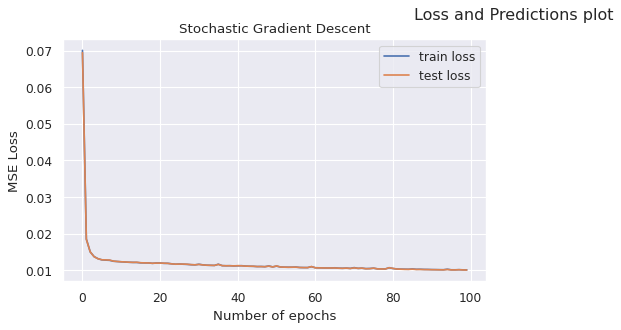

In [ ]:
tau = 0.01/L

#RUN
W_sgd, train_loss_sgd, test_loss_sgd = RUN_and_EVAL(stochastic_gradient_descent,X_train, y_train, tau, n_epochs, batch_size,beta,'test')
#PlOT
PLOT_history(train_loss_sgd,test_loss_sgd,'Stochastic Gradient Descent')

###Hyper Params search

Epoch: 5/100 | Test Loss: 0.014437459517310043
Epoch: 10/100 | Test Loss: 0.008735888810717324
Epoch: 15/100 | Test Loss: 0.008290807076967971
Epoch: 20/100 | Test Loss: 0.00824825468604399
Epoch: 25/100 | Test Loss: 0.008186166467838143
Epoch: 30/100 | Test Loss: 0.008242636008887591
Epoch: 35/100 | Test Loss: 0.018180078791602945
Epoch: 40/100 | Test Loss: 0.007822047289525284
Epoch: 45/100 | Test Loss: 0.008019895021975244
Epoch: 50/100 | Test Loss: 0.00789910616108768
Epoch: 55/100 | Test Loss: 0.01511998834558686
Epoch: 60/100 | Test Loss: 0.011461282102035222
Epoch: 65/100 | Test Loss: 0.008369960141620272
Epoch: 70/100 | Test Loss: 0.008637824974865784
Epoch: 75/100 | Test Loss: 0.009066527777545666
Epoch: 80/100 | Test Loss: 0.013412008833880504
Epoch: 85/100 | Test Loss: 0.009153201173189521
Epoch: 90/100 | Test Loss: 0.008358076632381608
Epoch: 95/100 | Test Loss: 0.0076457570199486655
Epoch: 100/100 | Test Loss: 0.007939627817053478
The training is over in 50.51s
Epoch: 5/10

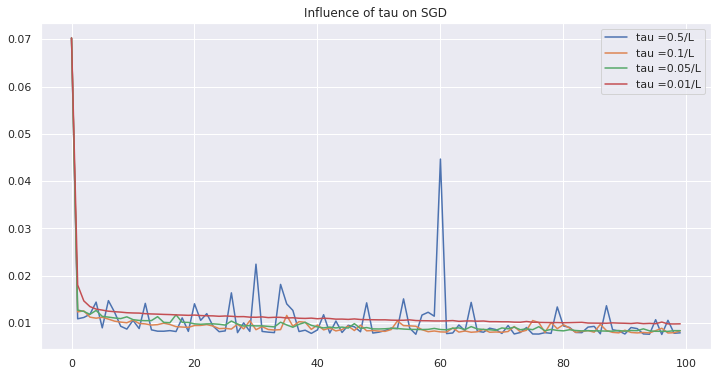

In [ ]:
taus=[0.5,0.1,0.05,0.01] #divided by L in RUN_and_EVAL function call

for tauu in taus:
  a, b, c  = RUN_and_EVAL(stochastic_gradient_descent,X_train, y_train, tauu/L, n_epochs,batch_size,beta,'val')
  plt.plot(c,label='tau ='+str(tauu)+'/L')
plt.title('Influence of tau on SGD')
plt.legend()
plt.show()

## 4 - Batch Gradient Descent (BGD)

**Batch Gradient Descent (BGD)** will perform the gradient computing for a batch of data, instead of the whole dataset or just unique samples. $ik$ is the set of indices drawn at random.
$$
\boxed{w^{(k+1)} = w^{(k)}-\tau \nabla L_{w}\left(w^{(k)}, X^{(ik)}, Y^{(ik)}\right)}
$$

$$
    \mathbf{w}_{k+1} = \mathbf{w}_k - \frac{\alpha_k}{|S_k|} \sum_{i \in S_k} \nabla f_i(\mathbf{w}_k)
$$
where $S_k$ is a set of indices drawn uniformly in $\{1,\dots,n\}$. For this lab, the samples will be drawn without replacement, so that $|S_k|=n$ results in a full gradient step, while $|S_k|=1$ corresponds to a basic stochastic gradient step. In this notebook, we will focus on using the same batch size across all iterations.

In [ ]:
#BGD
def batch_gradient_descent(X, Y, tau, n_epochs, batch_size, beta,test_val_data):
    W = np.zeros((X.shape[1],1))
    n_samples = X.shape[0]
    train_loss = []     
    test_loss = []
    X=X.values
    Y=Y.values

    if test_val_data=='test':
      XX=X_test
      YY=y_test
    if test_val_data=='val':
      XX=X_val
      YY=y_val


    for epoch in range(1, n_epochs+1):
        shuffle_index=[j for j in range(n_samples)]
        shuffle(shuffle_index)

        train_loss.append(MSE_loss(linear_prediction(X, W),Y))
        test_loss.append(MSE_loss(linear_prediction(XX, W),YY))


        for batch_list in batch(shuffle_index,n=batch_size):

            grad = linear_gradient(X[batch_list],W,Y[batch_list],lamda)
            W = W - tau*grad.T



        if epoch%5==0:
          #print("Epoch: {}/{} | Train Loss: {}".format(epoch, n_epochs, train_loss[-1]))
          print("Epoch: {}/{} | Test Loss: {}".format(epoch, n_epochs, test_loss[-1])) 
    return W, train_loss, test_loss

Epoch: 5/100 | Test Loss: 0.01831276090275915
Epoch: 10/100 | Test Loss: 0.014481077195062272
Epoch: 15/100 | Test Loss: 0.013344519266319839
Epoch: 20/100 | Test Loss: 0.012941330439175445
Epoch: 25/100 | Test Loss: 0.012665262272029012
Epoch: 30/100 | Test Loss: 0.012519778583777667
Epoch: 35/100 | Test Loss: 0.012409966521657847
Epoch: 40/100 | Test Loss: 0.012325151405282047
Epoch: 45/100 | Test Loss: 0.01223358513836268
Epoch: 50/100 | Test Loss: 0.012163685601213088
Epoch: 55/100 | Test Loss: 0.012097879832603256
Epoch: 60/100 | Test Loss: 0.012079348600800729
Epoch: 65/100 | Test Loss: 0.011980532554289354
Epoch: 70/100 | Test Loss: 0.01199907263820554
Epoch: 75/100 | Test Loss: 0.011891309756277673
Epoch: 80/100 | Test Loss: 0.011841006973043675
Epoch: 85/100 | Test Loss: 0.011762162932439332
Epoch: 90/100 | Test Loss: 0.011712502956740265
Epoch: 95/100 | Test Loss: 0.01168992378992693
Epoch: 100/100 | Test Loss: 0.011630580982728903
The training is over in 37.45s


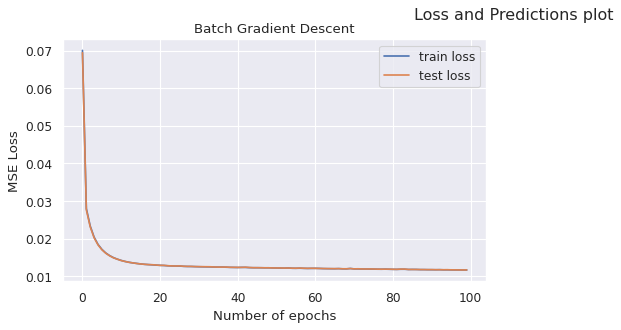

In [ ]:
tau = 0.01/L
batch_size=4

#RUN
W_bgd, train_loss_bgd, test_loss_bgd = RUN_and_EVAL(batch_gradient_descent,X_train, y_train, tau, n_epochs,batch_size,beta,'test')
#PlOT
PLOT_history(train_loss_bgd,test_loss_bgd,'Batch Gradient Descent')

###Hyper Params search

Epoch: 5/100 | Test Loss: 0.018066436423136517
Epoch: 10/100 | Test Loss: 0.014281169256312428
Epoch: 15/100 | Test Loss: 0.013174308006800304
Epoch: 20/100 | Test Loss: 0.012744330065552001
Epoch: 25/100 | Test Loss: 0.012502317760272741
Epoch: 30/100 | Test Loss: 0.01236875044367576
Epoch: 35/100 | Test Loss: 0.012240275975076301
Epoch: 40/100 | Test Loss: 0.012131246301370307
Epoch: 45/100 | Test Loss: 0.012049493600930846
Epoch: 50/100 | Test Loss: 0.01199007625783168
Epoch: 55/100 | Test Loss: 0.011932440408212902
Epoch: 60/100 | Test Loss: 0.011838504454728524
Epoch: 65/100 | Test Loss: 0.011821099356171547
Epoch: 70/100 | Test Loss: 0.011814116607274999
Epoch: 75/100 | Test Loss: 0.011692313171638918
Epoch: 80/100 | Test Loss: 0.011640863261019738
Epoch: 85/100 | Test Loss: 0.011571715808881297
Epoch: 90/100 | Test Loss: 0.011511890736284874
Epoch: 95/100 | Test Loss: 0.011482672456832078
Epoch: 100/100 | Test Loss: 0.011438033375758822
The training is over in 30.55s
Epoch: 5/10

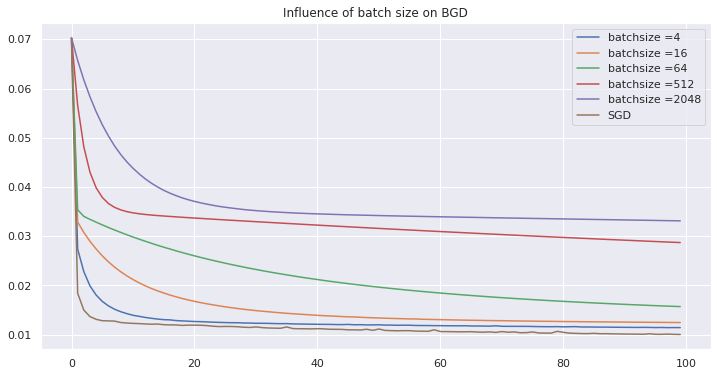

In [ ]:
#bacth size seek
tau = 0.01/L

batch_sizes=[4,16,64,512,2048]
for batch_sizee in batch_sizes:
  a, b, c = RUN_and_EVAL(batch_gradient_descent,X_train, y_train, tau, n_epochs,batch_sizee,beta,'val')
  plt.plot(c,label='batchsize ='+str(batch_sizee))
plt.title('Influence of batch size on BGD')
plt.plot(test_loss_sgd,label='SGD')
plt.legend()
plt.show()

## 5 - Momentum with SGD algorithm

$$
\boxed{\begin{array}{l}
v^{(k+1)} = \beta v^{(k)}+\tau \nabla_{w} L\left(w^{(k)}\right) \\
w^{(k+1)} = w^{(k)} - v^{(k+1)}
\end{array}}
$$

In [ ]:
def SGD_momentum(X, Y, tau, n_epochs, batch_size, beta, test_val_data):
    W = np.zeros((X.shape[1], 1))
    V = np.zeros((1, X.shape[1]))
    n_samples = X.shape[0]
    train_loss = []     
    test_loss = []
    X=X.values
    Y=Y.values

    if test_val_data=='test':
      XX=X_test
      YY=y_test
    if test_val_data=='val':
      XX=X_val
      YY=y_val


    for epoch in range(1, n_epochs+1):
      shuffle_index=[j for j in range(n_samples)]
      shuffle(shuffle_index)


      train_loss.append(MSE_loss(linear_prediction(X, W),Y))
      test_loss.append(MSE_loss(linear_prediction(XX, W),YY))

      for batch_list in batch(shuffle_index, n=1): #n=1 means batch size is fixed to 1

        grad = linear_gradient(X[batch_list],W,Y[batch_list],lamda)
        V = beta * V + tau * grad
        W = W - V.T


      if epoch%5==0:
        #print("Epoch: {}/{} | Train Loss: {}".format(epoch, n_epochs, train_loss[-1]))
        print("Epoch: {}/{} | Test Loss: {}".format(epoch, n_epochs, test_loss[-1])) 
    return W, train_loss, test_loss

Epoch: 5/100 | Test Loss: 0.012510128459263196
Epoch: 10/100 | Test Loss: 0.01122678956408527
Epoch: 15/100 | Test Loss: 0.0104718819342499
Epoch: 20/100 | Test Loss: 0.010219787226337583
Epoch: 25/100 | Test Loss: 0.00978168776561053
Epoch: 30/100 | Test Loss: 0.009550809289987175
Epoch: 35/100 | Test Loss: 0.009638196663638238
Epoch: 40/100 | Test Loss: 0.009365636194155844
Epoch: 45/100 | Test Loss: 0.009089369655866646
Epoch: 50/100 | Test Loss: 0.008940380914531516
Epoch: 55/100 | Test Loss: 0.009156677686238995
Epoch: 60/100 | Test Loss: 0.00924625669875325
Epoch: 65/100 | Test Loss: 0.008673793440002084
Epoch: 70/100 | Test Loss: 0.008839471653613836
Epoch: 75/100 | Test Loss: 0.008785536622939624
Epoch: 80/100 | Test Loss: 0.009080389081073387
Epoch: 85/100 | Test Loss: 0.009005541937674109
Epoch: 90/100 | Test Loss: 0.009517115664847264
Epoch: 95/100 | Test Loss: 0.008520474140427958
Epoch: 100/100 | Test Loss: 0.008292419600738458
The training is over in 58.01s


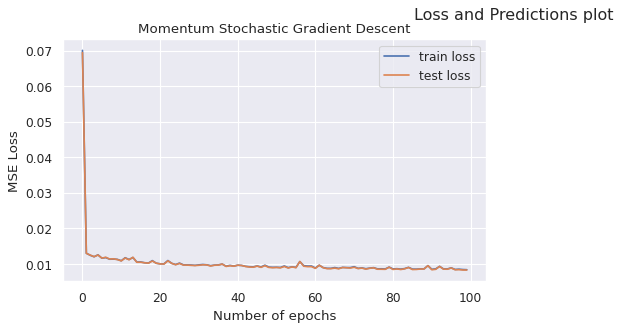

In [ ]:
tau = 0.01/L
beta=0.8

#RUN
W_sgdm, train_loss_sgdm, test_loss_sgdm = RUN_and_EVAL(SGD_momentum,X_train, y_train, tau, n_epochs,batch_size,beta,'test')
#PlOT
PLOT_history(train_loss_sgdm,test_loss_sgdm,'Momentum Stochastic Gradient Descent')

Epoch: 5/100 | Test Loss: 0.012687518875428164
Epoch: 10/100 | Test Loss: 0.01215498237619915
Epoch: 15/100 | Test Loss: 0.011816133198972767
Epoch: 20/100 | Test Loss: 0.011606936410580191
Epoch: 25/100 | Test Loss: 0.011227498744817453
Epoch: 30/100 | Test Loss: 0.011126512615274088
Epoch: 35/100 | Test Loss: 0.010863891539296915
Epoch: 40/100 | Test Loss: 0.010710743023736624
Epoch: 45/100 | Test Loss: 0.010554599194908174
Epoch: 50/100 | Test Loss: 0.010412023613396111
Epoch: 55/100 | Test Loss: 0.010363930485081958
Epoch: 60/100 | Test Loss: 0.01029320928897155
Epoch: 65/100 | Test Loss: 0.010191702185330324
Epoch: 70/100 | Test Loss: 0.009979602871429967
Epoch: 75/100 | Test Loss: 0.009955368005527541
Epoch: 80/100 | Test Loss: 0.009809430116486585
Epoch: 85/100 | Test Loss: 0.009750239417199286
Epoch: 90/100 | Test Loss: 0.009666685964682795
Epoch: 95/100 | Test Loss: 0.009595309269466182
Epoch: 100/100 | Test Loss: 0.009592189484307767
The training is over in 57.14s
Epoch: 5/10

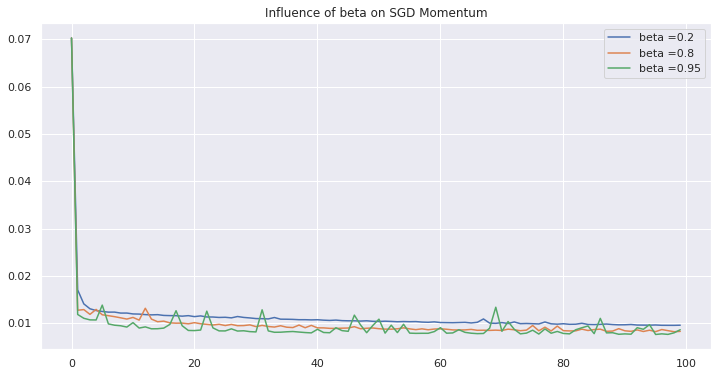

In [ ]:
#beta seek
tau = 0.01/L
betas=[0.2,0.8,0.95]

for betaa in betas:
  a, b, c = RUN_and_EVAL(SGD_momentum,X_train, y_train, tau, n_epochs,batch_size,betaa,'val')
  plt.plot(c,label='beta ='+str(betaa))
plt.title('Influence of beta on SGD Momentum')
plt.legend()
plt.show()

## 6 - Nesterov Accelerated Gradient (NAG)


$$
\boxed{\begin{array}{l}
v^{(i+1)} = \beta v^{(i)}+\tau \nabla_{w} L\left(w^{(i)} - \beta v^{(i)}\right) \\
w^{(i+1)} = w^{(i)} - v^{(i+1)}
\end{array}}
$$

This can be summed up as:

$$
\boxed{\begin{array}{l}
w^{(k+1)} =w^{(k)} - \tau \nabla_{w} L\left(w^{(k)} + \beta (w^{(k)} - w^{(k-1)})\right) + \beta (w^{(k)} - w^{(k-1)})
\end{array}}
$$

In [ ]:
def Nesterov_Accelerated_GD(X, Y, tau, n_epochs, batch_size, beta,test_val_data):
    W = np.zeros((X.shape[1], 1))
    V = np.zeros((1, X.shape[1]))
    n_samples = X.shape[0]
    train_loss = []
    test_loss = []
    X=X.values
    Y=Y.values

    if test_val_data=='test':
      XX=X_test
      YY=y_test
    if test_val_data=='val':
      XX=X_val
      YY=y_val


    for epoch in range(1, n_epochs+1):
      
        train_loss.append(MSE_loss(linear_prediction(X, W),Y))
        test_loss.append(MSE_loss(linear_prediction(XX, W),YY))

        W_next = W - beta * V.T
        grad = linear_gradient(X,W_next,Y,lamda)
        V = beta * V + tau * grad
        W = W - V.T


        if epoch%5==0:
          #print("Epoch: {}/{} | Train Loss: {}".format(epoch, n_epochs, train_loss[-1]))
          print("Epoch: {}/{} | Test Loss: {}".format(epoch, n_epochs, test_loss[-1])) 
    return W, train_loss, test_loss

Epoch: 5/100 | Test Loss: 0.03273490958901781
Epoch: 10/100 | Test Loss: 0.027348398037933572
Epoch: 15/100 | Test Loss: 0.02271881163327474
Epoch: 20/100 | Test Loss: 0.01959036134979693
Epoch: 25/100 | Test Loss: 0.017621634863554128
Epoch: 30/100 | Test Loss: 0.016355060827696465
Epoch: 35/100 | Test Loss: 0.015488340945757009
Epoch: 40/100 | Test Loss: 0.014861353275723459
Epoch: 45/100 | Test Loss: 0.01439258444985121
Epoch: 50/100 | Test Loss: 0.014036085407460265
Epoch: 55/100 | Test Loss: 0.013761784941951362
Epoch: 60/100 | Test Loss: 0.013548139435954794
Epoch: 65/100 | Test Loss: 0.013379345722019998
Epoch: 70/100 | Test Loss: 0.01324385460038988
Epoch: 75/100 | Test Loss: 0.013133270127381757
Epoch: 80/100 | Test Loss: 0.0130414859068249
Epoch: 85/100 | Test Loss: 0.012964039179542447
Epoch: 90/100 | Test Loss: 0.012897647523556441
Epoch: 95/100 | Test Loss: 0.012839880909556272
Epoch: 100/100 | Test Loss: 0.012788928149246261
The training is over in 4.94s


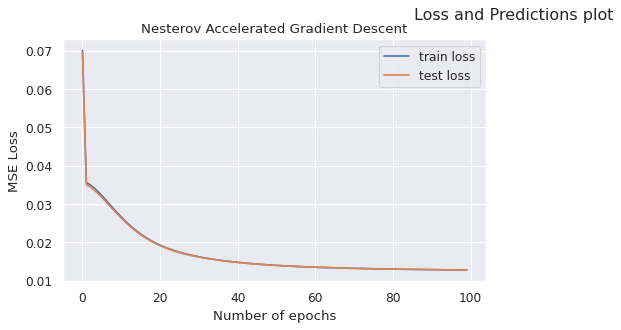

In [ ]:
tau = 1/L
beta=0.85

#RUN
W_nagd, train_loss_nagd, test_loss_nagd = RUN_and_EVAL(Nesterov_Accelerated_GD,X_train, y_train, tau, n_epochs,batch_size,beta,'test')
#PlOT
PLOT_history(train_loss_nagd,test_loss_nagd,'Nesterov Accelerated Gradient Descent')

Epoch: 5/100 | Test Loss: 0.03272032734196626
Epoch: 10/100 | Test Loss: 0.027843043586475037
Epoch: 15/100 | Test Loss: 0.023746052881234173
Epoch: 20/100 | Test Loss: 0.020861853127853342
Epoch: 25/100 | Test Loss: 0.018900830215951576
Epoch: 30/100 | Test Loss: 0.017539355502701734
Epoch: 35/100 | Test Loss: 0.01655604975680596
Epoch: 40/100 | Test Loss: 0.01581770682510593
Epoch: 45/100 | Test Loss: 0.015245894554579845
Epoch: 50/100 | Test Loss: 0.014792974525647498
Epoch: 55/100 | Test Loss: 0.014428351319488188
Epoch: 60/100 | Test Loss: 0.01413117409048286
Epoch: 65/100 | Test Loss: 0.01388650737750031
Epoch: 70/100 | Test Loss: 0.013683258029070064
Epoch: 75/100 | Test Loss: 0.013512983173471351
Epoch: 80/100 | Test Loss: 0.01336915303615259
Epoch: 85/100 | Test Loss: 0.013246662503661546
Epoch: 90/100 | Test Loss: 0.013141489229256342
Epoch: 95/100 | Test Loss: 0.013050444833697184
Epoch: 100/100 | Test Loss: 0.012970989138466267
The training is over in 4.94s
Epoch: 5/100 | T

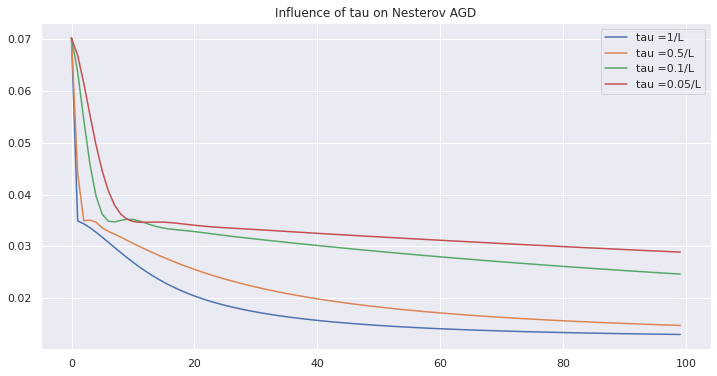

In [ ]:
taus=[1,0.5,0.1,0.05] #divided by L in RUN_and_EVAL function call
tau = 1/L
beta=0.85

for tauu in taus:
  a, b, c  = RUN_and_EVAL(Nesterov_Accelerated_GD,X_train, y_train, tauu/L, n_epochs,batch_size,beta,'val')
  plt.plot(c,label='tau ='+str(tauu)+'/L')
plt.title('Influence of tau on Nesterov AGD')
plt.legend()
plt.show()

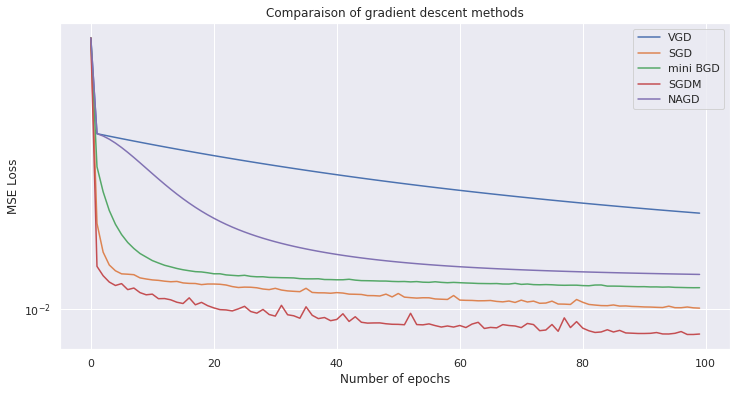

In [ ]:
plt.semilogy(test_loss_vgd, label = 'VGD')
plt.plot(test_loss_sgd, label = 'SGD')
plt.plot(test_loss_bgd, label = 'mini BGD')
plt.plot(test_loss_sgdm, label = 'SGDM')
plt.plot(test_loss_nagd, label = 'NAGD')

plt.xlabel("Number of epochs")
plt.ylabel("MSE Loss")
plt.title('Comparaison of gradient descent methods')
plt.legend()
plt.show()

## 7 - Adagrad (Adaptive gradient)

$$
\boxed{w^{(k+1)}=w^{(k)}-\frac{\tau}{\sqrt{G_{k}+\varepsilon}} \odot \nabla_{w} L\left(w^{(k)}\right)}
$$

In [ ]:
def adagrad(X, Y, tau, n_epochs, batch_size, beta, test_val_data):
    W = np.zeros((X.shape[1], 1))
    Gi = np.zeros((1, X.shape[1]))
    n_samples = X.shape[0]
    train_loss = []     
    test_loss = []
    X=X.values
    Y=Y.values

    if test_val_data=='test':
      XX=X_test
      YY=y_test
    if test_val_data=='val':
      XX=X_val
      YY=y_val


    for epoch in range(1, n_epochs+1):
        shuffle_index=[j for j in range(n_samples)]
        shuffle(shuffle_index)

        train_loss.append(MSE_loss(linear_prediction(X, W),Y))
        test_loss.append(MSE_loss(linear_prediction(XX, W),YY))

        for batch_list in batch(shuffle_index,batch_size):
            grad = linear_gradient(X[batch_list],W,Y[batch_list],lamda)
            Gi += grad ** 2
            new_tau = tau / np.sqrt(Gi + epsilon)
            W = W - np.multiply(new_tau.T, grad.T)


        if epoch%10==0:
          print("Epoch: {}/{} | Train Loss: {}".format(epoch, n_epochs, train_loss[-1]))
          print("Epoch: {}/{} | Test Loss: {}".format(epoch, n_epochs, test_loss[-1])) 
    return W, train_loss, test_loss

Epoch: 10/100 | Train Loss: 0.013660784760985012
Epoch: 10/100 | Test Loss: 0.013725082677952187
Epoch: 20/100 | Train Loss: 0.013082223652238587
Epoch: 20/100 | Test Loss: 0.013126115394878067
Epoch: 30/100 | Train Loss: 0.012798650948305968
Epoch: 30/100 | Test Loss: 0.012845734186660625
Epoch: 40/100 | Train Loss: 0.01261139351639569
Epoch: 40/100 | Test Loss: 0.012643361721248681
Epoch: 50/100 | Train Loss: 0.01245501783815171
Epoch: 50/100 | Test Loss: 0.01248937815831143
Epoch: 60/100 | Train Loss: 0.012349273246105193
Epoch: 60/100 | Test Loss: 0.01236864461080181
Epoch: 70/100 | Train Loss: 0.012228139052842616
Epoch: 70/100 | Test Loss: 0.01226622037066555
Epoch: 80/100 | Train Loss: 0.012146107946560243
Epoch: 80/100 | Test Loss: 0.012164650337031218
Epoch: 90/100 | Train Loss: 0.012055152543105234
Epoch: 90/100 | Test Loss: 0.012084516826972166
Epoch: 100/100 | Train Loss: 0.011983435615995913
Epoch: 100/100 | Test Loss: 0.012009908041402633
The training is over in 75.81s


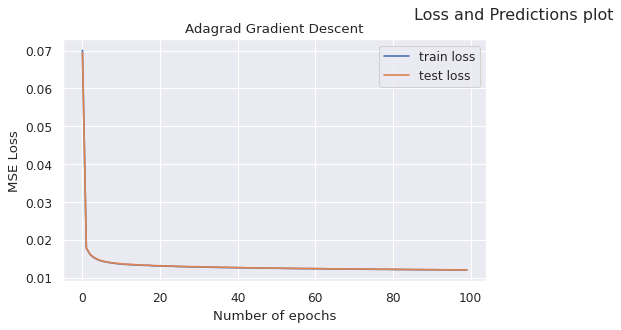

In [ ]:
#RUN
epsilon = 10**(-8)
batch_size=1
tau = 0.01/L

W_adag, train_loss_adag, test_loss_adag = RUN_and_EVAL(adagrad,X_train, y_train, tau, n_epochs,batch_size,beta,'test')
#PlOT
PLOT_history(train_loss_adag,test_loss_adag,'Adagrad Gradient Descent')

## 8 - Adam (Adaptive moment estimation)


$$
\boxed{
m_{k}=\beta_{1} m_{k-1}+\left(1-\beta_{1}\right) \nabla_{w} L\left(w^{(k)}\right) \\
v_{k}=\beta_{2} v_{k-1}+\left(1-\beta_{2}\right) \nabla_{w} L\left(w^{(k)}\right)^{2}\\
\hat{m}_{k}=\frac{m_{k}}{1-\beta_{1}} \\
\hat{v}_{k}=\frac{v_{k}}{1-\beta_{2}}\\
w^{(k+1)} = w^{(k)}-\frac{\tau}{\sqrt{\hat{v}_{k}}+\varepsilon} \hat{m}_{k}
}
$$





In [ ]:
def adam(X, Y, tau, n_epochs, batch_size, beta, test_val_data):
    W = np.zeros((X.shape[1], 1))
    m = np.zeros((1, X.shape[1]))
    v = np.zeros((1, X.shape[1]))
    n_samples = X.shape[0]
    train_loss = []     
    test_loss = []
    X=X.values
    Y=Y.values

    if test_val_data=='test':
      XX=X_test
      YY=y_test
    if test_val_data=='val':
      XX=X_val
      YY=y_val


    for epoch in range(1, n_epochs+1):
        shuffle_index=[j for j in range(n_samples)]
        shuffle(shuffle_index)

        train_loss.append(MSE_loss(linear_prediction(X, W),Y))
        test_loss.append(MSE_loss(linear_prediction(XX, W),YY))

        for batch_list in batch(shuffle_index,batch_size):

           # Compute the gradient, and its first and second moment estimation
            grad = linear_gradient(X[batch_list],W,Y[batch_list],lamda)

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * grad ** 2
            
            # Compute the bias-corrected versions of the moment
            m_hat = m / (1 - beta1)
            v_hat = v / (1 - beta2)
            new_tau = tau / (np.sqrt(v_hat) + epsilon)
            
            # Update the weights
            W = W - np.multiply(new_tau.T, m_hat.T)
            

        if epoch%10==0:
          print("Epoch: {}/{} | Train Loss: {}".format(epoch, n_epochs, train_loss[-1]))
          print("Epoch: {}/{} | Test Loss: {}".format(epoch, n_epochs, test_loss[-1])) 
    return W, train_loss, test_loss

Epoch: 10/100 | Train Loss: 0.012504692963111665
Epoch: 10/100 | Test Loss: 0.012465257387409175
Epoch: 20/100 | Train Loss: 0.011228030323826433
Epoch: 20/100 | Test Loss: 0.011257986393351464
Epoch: 30/100 | Train Loss: 0.010699205067602195
Epoch: 30/100 | Test Loss: 0.010656224028428207
Epoch: 40/100 | Train Loss: 0.010261606363388825
Epoch: 40/100 | Test Loss: 0.010252208334854816
Epoch: 50/100 | Train Loss: 0.009931600479944666
Epoch: 50/100 | Test Loss: 0.009913195845319663
Epoch: 60/100 | Train Loss: 0.009807129259906134
Epoch: 60/100 | Test Loss: 0.009802901202113797
Epoch: 70/100 | Train Loss: 0.009494363905710058
Epoch: 70/100 | Test Loss: 0.009452900224972208
Epoch: 80/100 | Train Loss: 0.00933987144894939
Epoch: 80/100 | Test Loss: 0.009270930585733677
Epoch: 90/100 | Train Loss: 0.009213425011399313
Epoch: 90/100 | Test Loss: 0.009152632553591613
Epoch: 100/100 | Train Loss: 0.009182285108181126
Epoch: 100/100 | Test Loss: 0.009141300324888751
The training is over in 57.13

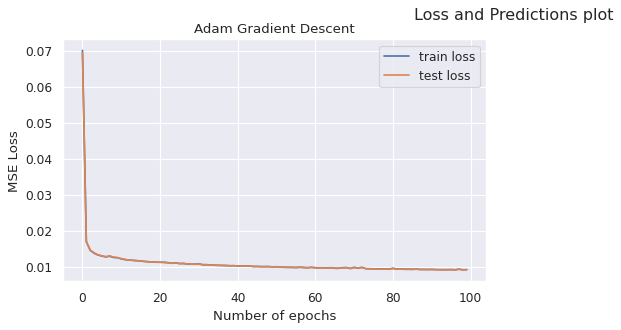

In [ ]:
#RUN
batch_size=4
epsilon = 1e-8
beta1 = 0.9
beta2 = 0.999
tau = 0.001/L
W_adam, train_loss_adam, test_loss_adam = RUN_and_EVAL(adam,X_train, y_train, tau, n_epochs,batch_size,beta,'test')
#PlOT
PLOT_history(train_loss_adam,test_loss_adam,'Adam Gradient Descent')

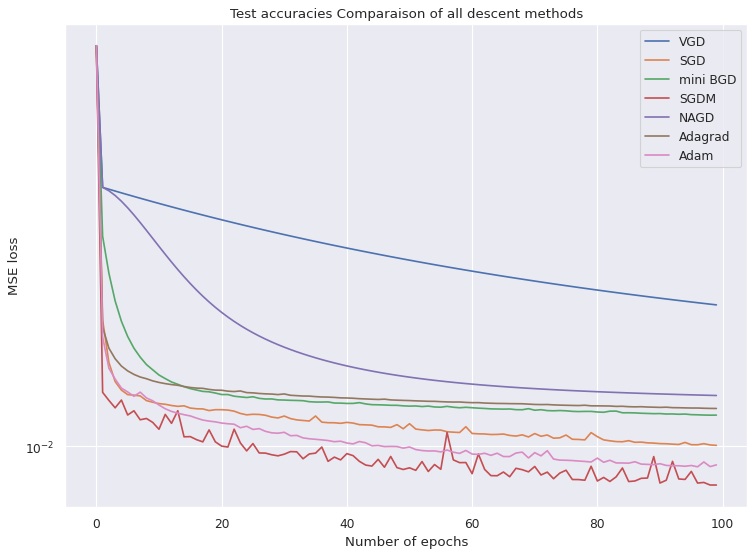

In [ ]:
plt.figure(figsize=(11, 8), dpi=80)
plt.semilogy(test_loss_vgd, label = 'VGD')
plt.plot(test_loss_sgd, label = 'SGD')
plt.plot(test_loss_bgd, label = 'mini BGD')
plt.plot(test_loss_sgdm, label = 'SGDM')
plt.plot(test_loss_nagd, label = 'NAGD')
plt.plot(test_loss_adag, label = 'Adagrad')
plt.plot(test_loss_adam, label = 'Adam')

plt.xlabel("Number of epochs")
plt.ylabel("MSE loss")
plt.title('Test accuracies Comparaison of all descent methods')
plt.legend()
plt.show()

### Test of regularization values

Epoch: 5/100 | Test Loss: 0.01735770271886413
Epoch: 10/100 | Test Loss: 0.015756100524834695
Epoch: 15/100 | Test Loss: 0.017242435350090474
Epoch: 20/100 | Test Loss: 0.015852034954615953
Epoch: 25/100 | Test Loss: 0.01681718304341597
Epoch: 30/100 | Test Loss: 0.01746162809956914
Epoch: 35/100 | Test Loss: 0.01615139439447559
Epoch: 40/100 | Test Loss: 0.015874961939779976
Epoch: 45/100 | Test Loss: 0.016082240403901417
Epoch: 50/100 | Test Loss: 0.01657498988746617
Epoch: 55/100 | Test Loss: 0.0163587140017314
Epoch: 60/100 | Test Loss: 0.0156890966016242
Epoch: 65/100 | Test Loss: 0.015817394509074597
Epoch: 70/100 | Test Loss: 0.015959642819541906
Epoch: 75/100 | Test Loss: 0.01663759124340253
Epoch: 80/100 | Test Loss: 0.016602458163835754
Epoch: 85/100 | Test Loss: 0.015856649136256125
Epoch: 90/100 | Test Loss: 0.016388314448181854
Epoch: 95/100 | Test Loss: 0.01578069633154421
Epoch: 100/100 | Test Loss: 0.01610325627122331
The training is over in 58.65s
Epoch: 5/100 | Test L

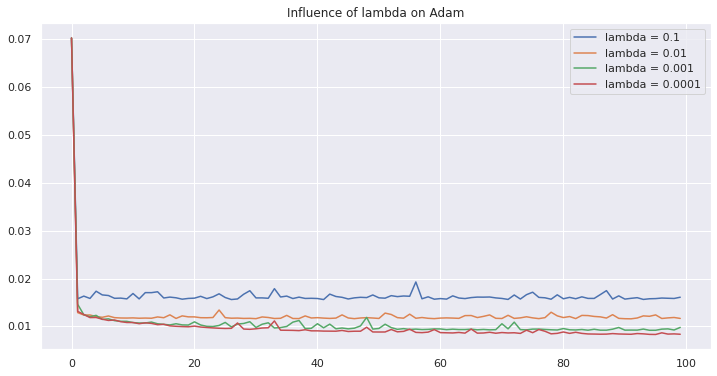

In [ ]:
lamdas=[0.1,0.01,0.001,0.0001]
tau = 0.01/L
beta=0.8

for lamda in lamdas:
  W_sgdm_optimal, b, c  = RUN_and_EVAL(SGD_momentum,X_train, y_train, tau, n_epochs,batch_size,beta,'val')
  plt.plot(c,label='lambda = '+str(lamda))
plt.title('Influence of lambda on Adam')
plt.legend()
plt.show()
lamda=0

### Final Prediction Results

0.008415754524925335

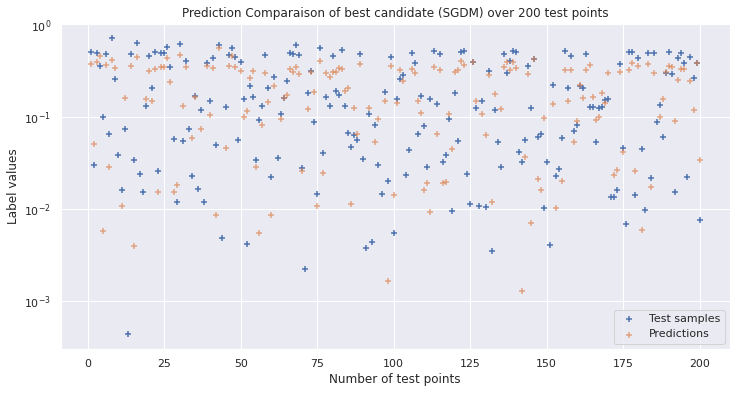

In [ ]:
#Plot of optimum fitting
nb_pts=200
 
fig = plt.figure()
ax = plt.gca()
k=np.linspace(1,len(y_test),len(y_test))
plt.scatter(k[:nb_pts],y_test.values[:nb_pts],marker='+', label='Test samples')
plt.scatter(k[:nb_pts],linear_prediction(X_test.values,W_sgdm_optimal)[:nb_pts],marker='+',alpha=0.7,label='Predictions')
ax.set_yscale('log')
plt.xlabel("Number of test points")
plt.ylabel("Label values")
plt.title('Prediction Comparaison of best candidate (SGDM) over 200 test points')
plt.legend()
MSE_loss(linear_prediction(X_test.values,a),y_test)